In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import os
from helpers.datasets import *
cm = matplotlib.cm.get_cmap('Greens')
plt.style.use("science.mplstyle")
from sklearn.model_selection import train_test_split



np.random.seed(8)

from matplotlib.backends.backend_pdf import PdfPages as pp

In [2]:
# directories
curtains_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/"

# function input paramters
n_points = 100000
dataset_id = "triangle"
n_features = 2 # including context
dataset_config_string = f"{dataset_id}_npoints{n_points}_nfeatures{n_features}/"


data_dir = os.path.join(curtains_dir, dataset_config_string, "data")

print("Making dataset directory at", data_dir, "...")
os.makedirs(data_dir, exist_ok=True)


Making dataset directory at /global/home/users/rrmastandrea/CURTAINS_SALAD/triangle_npoints100000_nfeatures2/data ...


In [3]:
# dataset generation parameters
context_endpoints = (0, .9)


bands_dict = {
              "sb1": [0, .3],
              "sr" : [.3, .6],
              "sb2": [.6, .9],
            }

print("Generating datasets...")


data_sim = make_dataset_with_context(n_points, n_features-1, dataset_id, context_endpoints, (0.25/0.5))
data_dat = make_dataset_with_context(n_points, n_features-1, dataset_id, context_endpoints, (0.75/0.5))

print("SIM shape:", data_sim.shape)
print("DAT shape:", data_dat.shape)







Generating datasets...
SIM shape: (100000, 2)
DAT shape: (100000, 2)


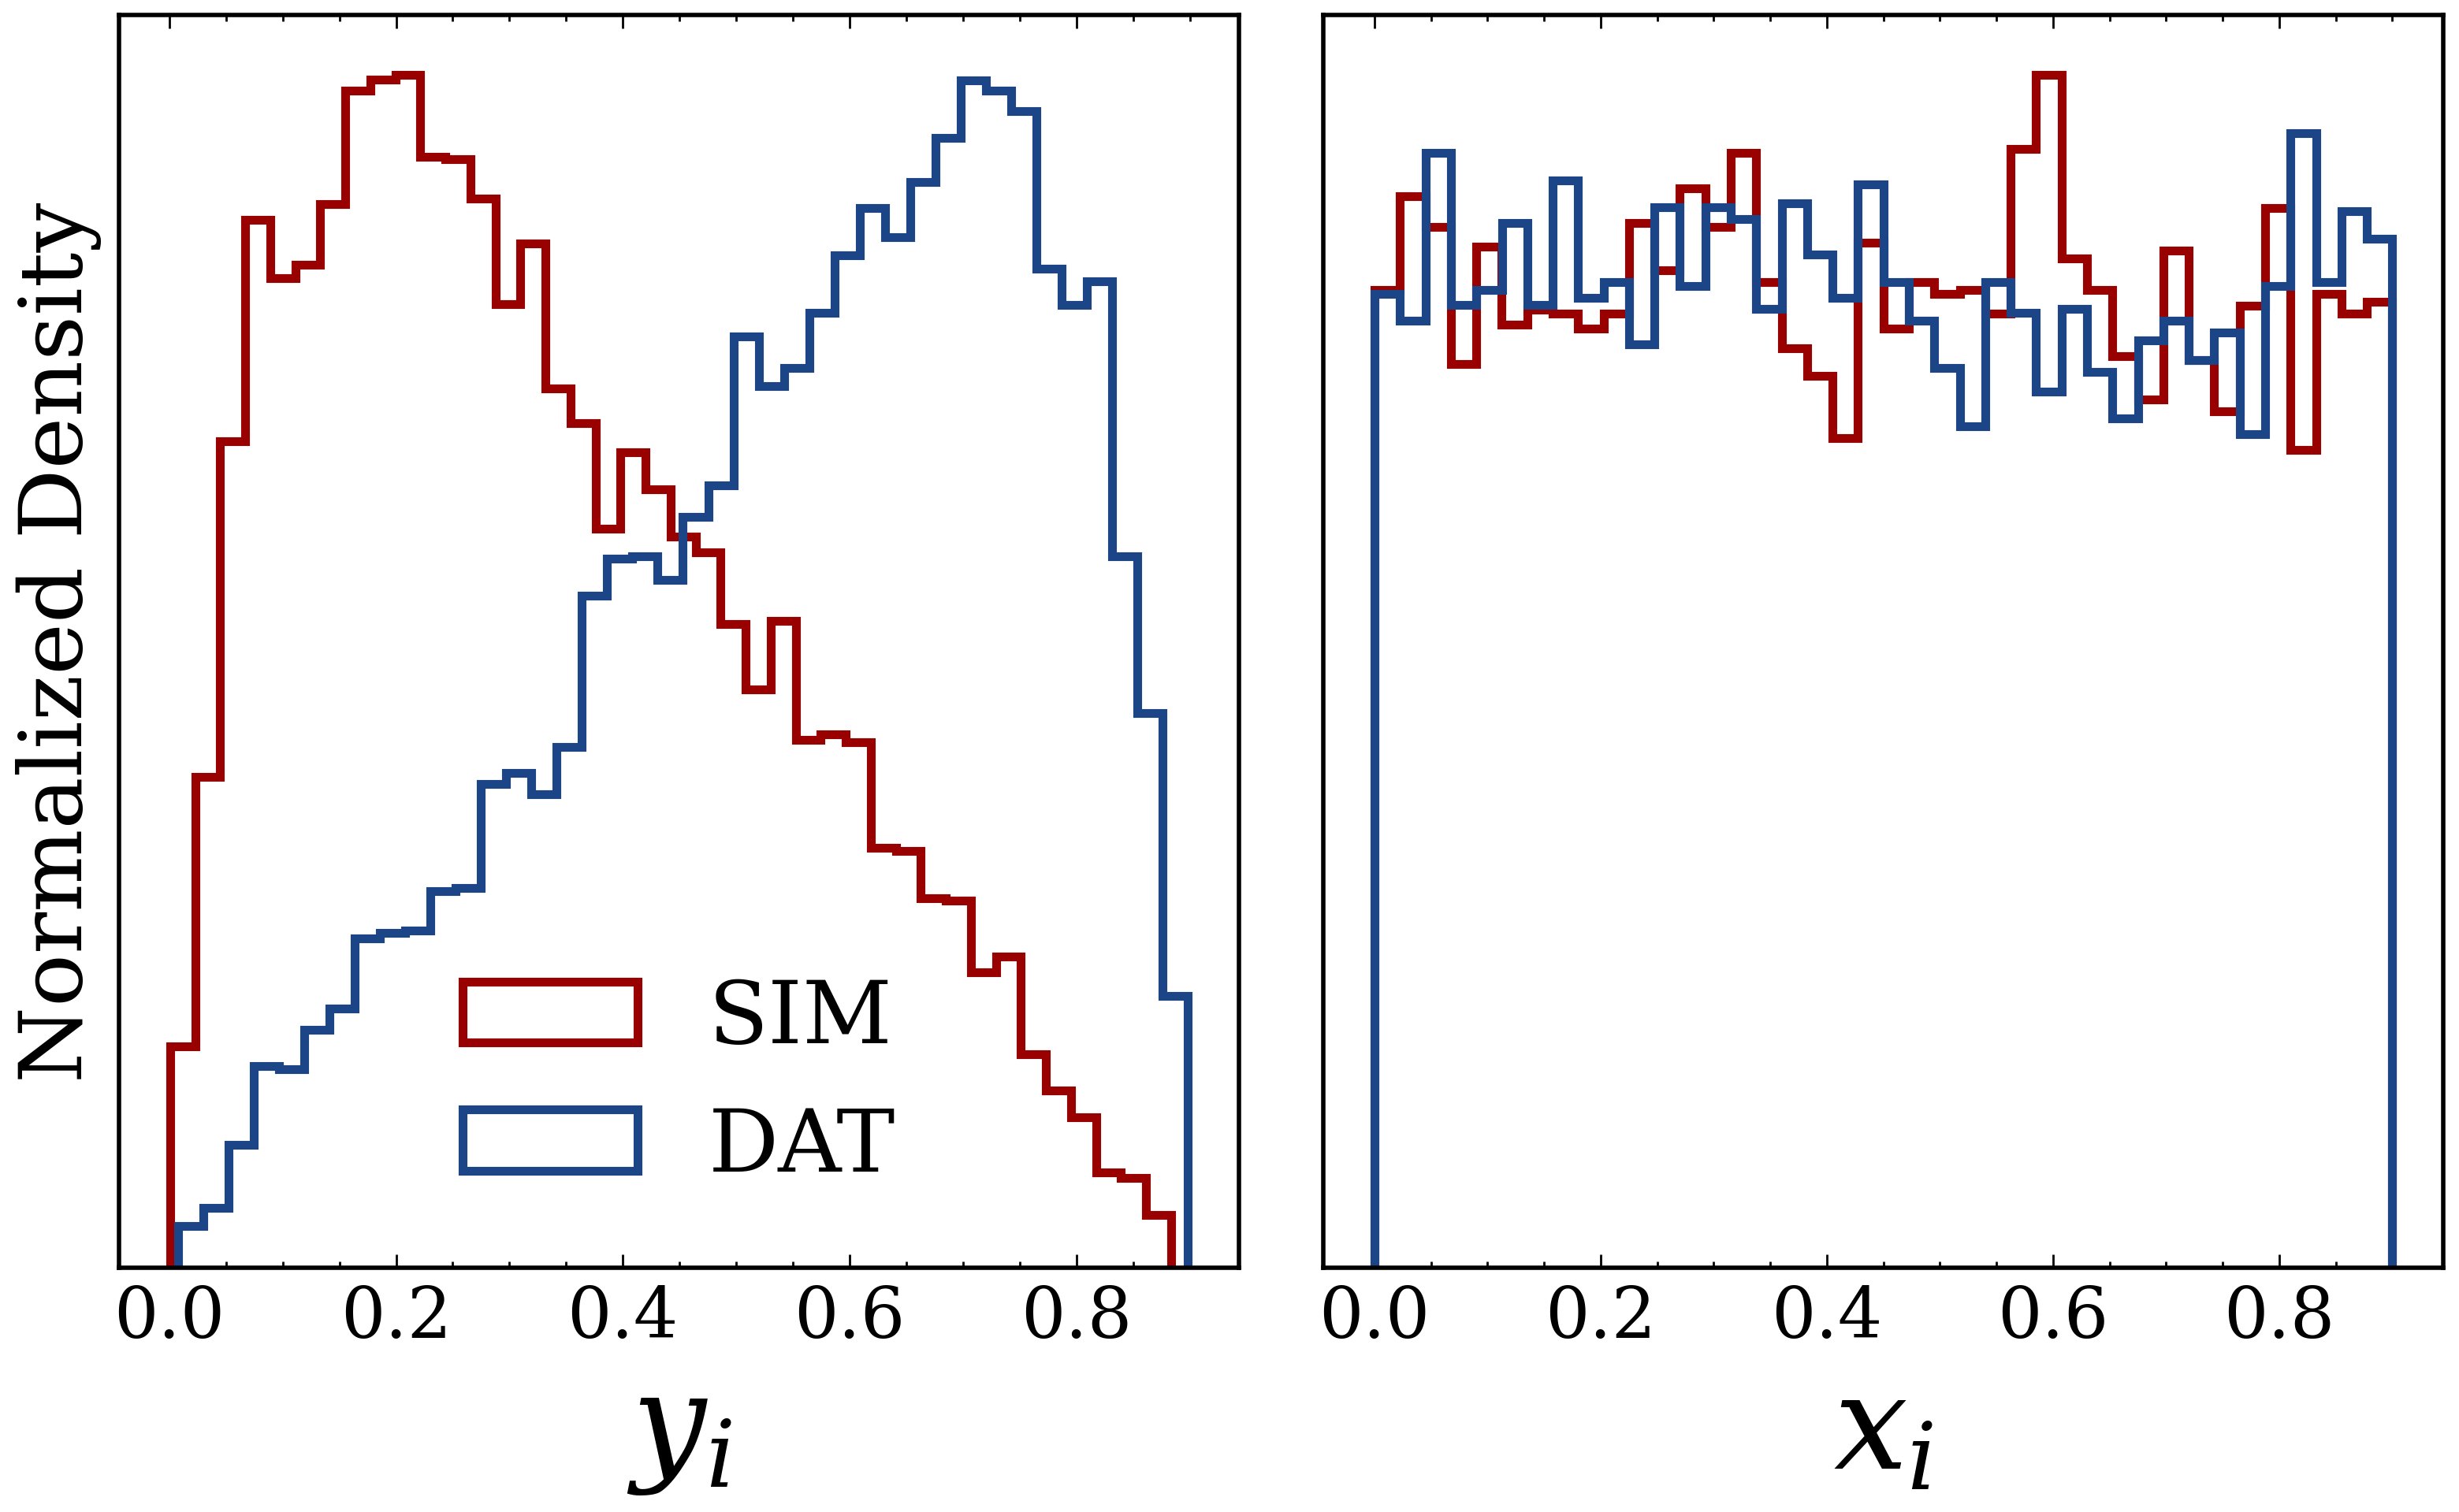

In [10]:
# features plots

sim_color = "#990000"
trans_color = "#674ea7"
dat_color = "#1c4587"

dpi = 800

alpha = 0.5
n_plot = 10000
bins = 40
w = 2


import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1 #set the value globally

feature_labels = ["$y_i$", "$x_i$"]



n_features = 2

    

fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 5))

for i in range(n_features):
    ax[i].hist(data_sim[:n_plot,i], bins = bins, density = True, label = "SIM", histtype = "step", color = sim_color, linewidth = w)
    ax[i].hist(data_dat[:n_plot,i], bins = bins, density = True, label = "DAT", histtype = "step", color = dat_color, linewidth = w)

    ax[i].set_xlabel(feature_labels[i], fontsize = 30)
    ax[i].set_yticks([])
    
ax[0].set_ylabel("Normalized Density")  
ax[0].legend(fontsize = 20, loc = "lower center")  
plt.tight_layout()
fig.savefig("paper_plots/toy_features.pdf", dpi = dpi)
fig.show()

    

   




In [4]:
def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, -1] >= mass_range[0]) & (dataset[:, -1] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)

        return selected_data
    
    
    
def minmaxscale(data, col_minmax, lower = -3.0, upper = 3.0):
        
       
        minmaxscaled_data = np.zeros(data.shape)
        for col in range(data.shape[1]):

            X_std = (data[:, col] - col_minmax[col][0]) / (col_minmax[col][1] - col_minmax[col][0])
            minmaxscaled_data[:, col] = X_std * (upper - lower) + lower
        
        return minmaxscaled_data
     



## Pull from ob1 -> ob2 to visualize and get column rescales

In [7]:
col_minmax = []
for col in range(2):
    col_minmax.append([np.min(data_sim[:, col]), np.max(data_sim[:, col])])
    
print(col_minmax)


np.save(os.path.join(data_dir, "col_minmax.npy"), col_minmax)


[[0.0007029778774502497, 0.8973594683436931], [6.4514152148476006e-06, 0.8999975518529784]]


## Nice plots of the dataset

In [ ]:


fig, ax = plt.subplots(1, 2, figsize = (12, 4))
fig.subplots_adjust(right=0.8, left = 0.2)

n_plot = 5000

bins = 40




sc_sim = ax[0].scatter(trial_data_sim[:n_plot,0], trial_data_sim[:n_plot,1], c = trial_data_sim[:n_plot,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(trial_data_dat[:n_plot,0], trial_data_dat[:n_plot,1], c = trial_data_dat[:n_plot,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)




plt.show()


pp = PdfPages(os.path.join("paper_plots", f"toy_model_datasets.pdf"))


fig, ax = plt.subplots(1, 2, figsize = (12, 6))
ax = ax.flatten()

ax[0].hist(trial_data_sim[:n_plot,1], bins = bins, density = True, label = "SIM", histtype = "step", color = "red")
ax[0].hist(trial_data_dat[:n_plot,1], bins = bins, density = True, label = "DAT", histtype = "step", color = "blue")
ax[0].legend(loc = "lower center")
ax[0].set_xlabel("$x_i$")

ax[1].hist(trial_data_sim[:n_plot,0], bins = bins, density = True, label = "SIM", histtype = "step", color = "red")
ax[1].hist(trial_data_dat[:n_plot,0], bins = bins, density = True, label = "DAT", histtype = "step", color = "blue")
ax[1].legend(loc = "lower center")
ax[1].set_xlabel("$y_i$")
        
ax[0].set_ylabel("Density")

fig.show()
pp.savefig()

pp.close()




# Plot specific bands

In [ ]:


band = "sb1"


trial_data_sim = pull_from_mass_range(data_sim, [bands_dict[band]])
trial_data_dat = pull_from_mass_range(data_dat, [bands_dict[band]])

print(f"SIM {band} shape:", trial_data_sim.shape)
print(f"DAT {band} shape:", trial_data_dat.shape)

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.subplots_adjust(right=0.8)

sc_sim = ax[0].scatter(trial_data_sim[:,0], trial_data_sim[:,1], c = trial_data_sim[:,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(trial_data_dat[:,0], trial_data_dat[:,1], c = trial_data_dat[:,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)

plt.show()


fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 4))
for i in range(n_features):
    ax[i].hist(trial_data_sim[:,i], density = True, label = "p_1", histtype = "step")
    ax[i].hist(trial_data_dat[:,i], density = True, label = "p_2", histtype = "step")
    ax[i].legend()
    ax[i].set_title(f"f{i}")

fig.show()






In [ ]:
# pull sb1, sb2


trial_data_sim_mms = minmaxscale(trial_data_sim, col_minmax)
trial_data_dat_mms = minmaxscale(trial_data_dat, col_minmax)



fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.subplots_adjust(right=0.8)

sc_sim = ax[0].scatter(trial_data_sim_mms[:,0], trial_data_sim_mms[:,1], c = trial_data_sim_mms[:,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(trial_data_dat_mms[:,0], trial_data_dat_mms[:,1], c = trial_data_dat_mms[:,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)

plt.show()


fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 4))
for i in range(n_features):
    ax[i].hist(trial_data_sim_mms[:,i], density = True, label = "p_1", histtype = "step")
    ax[i].hist(trial_data_dat_mms[:,i], density = True, label = "p_2", histtype = "step")
    ax[i].legend()
    ax[i].set_yscale("log")
    ax[i].set_title(f"f{i}")

fig.show()





In [5]:

train_sim = pull_from_mass_range(data_sim, [bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"]])
train_dat = pull_from_mass_range(data_dat, [bands_dict["sb1"], bands_dict["sb2"]])

sim_train, sim_val = train_test_split(train_sim, test_size=0.2, random_state=42)
dat_train, dat_val = train_test_split(train_dat, test_size=0.2, random_state=42)


In [8]:

# save
np.save(os.path.join(data_dir, "train_sim.npy"), sim_train)
np.save(os.path.join(data_dir, "val_sim.npy"), sim_val)
np.save(os.path.join(data_dir, "train_dat.npy"), dat_train)
np.save(os.path.join(data_dir, "val_dat.npy"), dat_val)


# prepare the classifier traininf
sr_sim = pull_from_mass_range(data_sim, [bands_dict["sr"]])
sr_dat = pull_from_mass_range(data_dat, [bands_dict["sr"]])
print(sr_sim.shape,sr_dat.shape )


np.save(os.path.join(data_dir, "classif_train_sim.npy"), sr_sim)
np.save(os.path.join(data_dir, "classif_train_dat.npy"), sr_dat)




(33483, 2) (33357, 2)
